In [1]:
import os

import pandas as pd
import torch

In [2]:
from dotenv import load_dotenv

# 현재 작업 디렉토리 가져오기
current_dir = os.getcwd()  # 현재 Jupyter Notebook의 작업 디렉토
env_path = os.path.join(current_dir, '../.env')

# .env 파일 로드
load_dotenv(env_path)

True

In [3]:
db_path=os.getenv("DATA_PATH")
ecg_data=pd.read_csv(f'{db_path}/ptbxl_database.csv')
ecg_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


## 모델 및 하이퍼파라미터 준비
BCResNet의 cnn_first의 stride나 다른 conv의 stride에 따라 입력 또는 출력의 크기가 달라짐.
이는 조절해가면서 실험필요

In [4]:
from ver4_journal.common.network.BCResNets import BCResNets

tau = 1
in_channel = 12
model = BCResNets(int(tau * 8), 5, in_channel)

if in_channel == 1:
    sample = torch.randn(1,12,1000)
else:
    sample = torch.randn(1,12,1000)
    #sample = torch.randn(1,12,20,48)

print(sample.shape)
pred = model(sample)
pred.shape

torch.Size([1, 12, 1000])


torch.Size([1, 5])

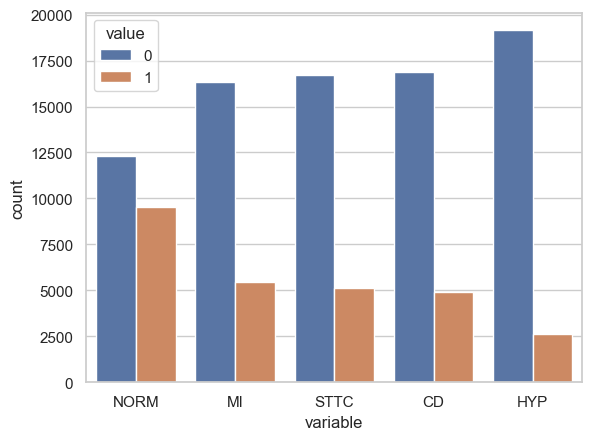

In [5]:
from ver5_journal.common.data.create_final_data import create_final_data
from ver5_journal.common.data.ECG_Data import ECG_Data
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
from torch.utils.data import DataLoader
import numpy as np
from ver5_journal.common.network.BCResNets import BCResNets

# 레이블 순서 : 데이터가 많은 순
label_columns = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
num_epochs = 50

# train/val/test 분리
final_data = create_final_data()
ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

# Training 함수 정의
def train_one_epoch(model, train_loader, optimizer, loss_fn, device, label_idx):
    model.train()
    train_loss = 0
    y_true = []
    y_pred = []

    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()

        output = model(data)
        label_data = label[:, label_idx].float().to(device)  # (batch_size)로 맞춤

        loss = loss_fn(output.squeeze(-1), label_data)  # Sigmoid 제거
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Accuracy 계산을 위해 예측값 저장
        y_true.extend(label_data.cpu().numpy())
        y_pred.extend((torch.sigmoid(output).detach().cpu().numpy() > 0.5).astype(int))  # 임계값 0.5 적용
    
    avg_loss = train_loss / len(train_loader)
    train_accuracy = accuracy_score(np.array(y_true), np.array(y_pred))  # 정확도 계산
    return avg_loss, train_accuracy

# Validation 함수 정의
def validate_one_epoch(model, val_loader, loss_fn, device, label_idx):
    model.eval()
    val_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)

            output = model(data)
            label_data = label[:, label_idx].float().to(device)  # (batch_size)로 맞춤
            loss = loss_fn(output.squeeze(-1), label_data)  # Sigmoid 제거
            val_loss += loss.item()

            # AUC 및 Accuracy 계산을 위한 예측값 저장
            y_true.extend(label_data.cpu().numpy())
            y_pred.extend(torch.sigmoid(output).detach().cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_auc = roc_auc_score(y_true, y_pred)
    val_accuracy = accuracy_score(np.array(y_true), (np.array(y_pred) > 0.5).astype(int))  # 정확도 계산
    return avg_val_loss, val_auc, val_accuracy

# 데이터셋의 0과 1 비율에 맞춘 가중치 계산 함수
def calculate_class_weight(dataset, label_idx):
    labels = dataset[:, label_idx]  # 넘파이 배열에 맞게 인덱스로 접근
    num_ones = np.sum(labels == 1)
    num_zeros = np.sum(labels == 0)
    
    # 가중치 계산 (1의 개수가 0인 경우 대비)
    if num_ones == 0:
        weight = 1.0  # 1이 없는 경우 가중치 1로 설정
    else:
        weight = num_zeros / num_ones  # 가중치 
    print (f'num_zeros: {num_zeros}, num_ones: {num_ones}')
    print(f'weight: {weight: .4f}')    
    return weight

In [6]:
# 모델 학습 루프
for i, label in enumerate(label_columns):
    print(f"Training model for label: {label}")
    
    # 각 레이블에 대해 데이터 추출
    ECG_train_label = ECG_train[ECG_train[label].isin([0, 1])].reset_index(drop=True)
    ECG_val_label = ECG_val[ECG_val[label].isin([0, 1])].reset_index(drop=True)
    # ECG_test_label = ECG_test[ECG_test[label].isin([0, 1])].reset_index(drop=True)

    # 데이터 로더 준비
    train_dataset_label = ECG_Data(ECG_train_label)
    train_loader_label = DataLoader(train_dataset_label, batch_size=32, shuffle=True)

    val_dataset_label = ECG_Data(ECG_val_label)
    val_loader_label = DataLoader(val_dataset_label, batch_size=32, shuffle=True)

    # 모델 정의 및 학습
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = BCResNets(16, 1, in_channel=12).to(device)

    optim = torch.optim.Adam(model.parameters(), lr=1e-2)
    weight = calculate_class_weight(ECG_train[label_columns].values, i)

    # Weighted BCEWithLogitsLoss 설정
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight], dtype=torch.float32).to(device))
    # loss_fn = torch.nn.BCELoss()

    best_val_auc = float('-inf')
    model_path = f'../common/weight_BCE_models/{label}_model.pth'
    label_idx = label_columns.index(label)

    for epoch in range(num_epochs):
        # Training 단계
        train_loss, train_accuracy = train_one_epoch(model, train_loader_label, optim, loss_fn, device, label_idx)
        
        # Validation 단계
        val_loss, val_auc, val_accuracy = validate_one_epoch(model, val_loader_label, loss_fn, device,label_idx)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}, Val Accuracy: {val_accuracy:.4f}')
        
        # 최적 AUC 모델 저장
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), model_path)
            print(f"Best model saved for label {label} with AUC {best_val_auc:.4f}")

    print(f"Training completed for label: {label}. Best AUC: {best_val_auc:.4f}")
    print("=====================================================================")

Training model for label: NORM
num_zeros: 9822, num_ones: 7596
weight:  1.2930
Epoch 1/50, Train Loss: 0.5382, Train Accuracy: 0.7718
Epoch 1/50, Val Loss: 0.4745, Val AUC: 0.9042, Val Accuracy: 0.7966
Best model saved for label NORM with AUC 0.9042
Epoch 2/50, Train Loss: 0.4226, Train Accuracy: 0.8326
Epoch 2/50, Val Loss: 0.4696, Val AUC: 0.9252, Val Accuracy: 0.8039
Best model saved for label NORM with AUC 0.9252
Epoch 3/50, Train Loss: 0.4035, Train Accuracy: 0.8405
Epoch 3/50, Val Loss: 0.4120, Val AUC: 0.9249, Val Accuracy: 0.8346
Epoch 4/50, Train Loss: 0.3869, Train Accuracy: 0.8495
Epoch 4/50, Val Loss: 0.4468, Val AUC: 0.9307, Val Accuracy: 0.8117
Best model saved for label NORM with AUC 0.9307
Epoch 5/50, Train Loss: 0.3797, Train Accuracy: 0.8499
Epoch 5/50, Val Loss: 0.4216, Val AUC: 0.9310, Val Accuracy: 0.8520
Best model saved for label NORM with AUC 0.9310
Epoch 6/50, Train Loss: 0.3745, Train Accuracy: 0.8537
Epoch 6/50, Val Loss: 0.4471, Val AUC: 0.9248, Val Accuracy